In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
import cvxpy as cvx
from numpy.random import randn
import matplotlib.pyplot as plt
%matplotlib inline

# Problem 1

As it __inequality constrained LP in 2 dimensions__, we have:
$$
\underset{x}{\min} c^\top x \\
\text{subj. to.}~ Ax \leq b
$$
We also assume that $x = (0,0)$ is feasible. We have to implement an __interior-point method__, that gives us:
$$
\underset{x,\\t \rightarrow \infty}{\min} \{ t c^\top x - \sum_i \log \left( A_i x - b_i \right) \}
$$

In [2]:
def solve_newton(f, x0, jac, hess, eps = 1e-3, gamma = 0.5):
    """Newton method implementation.
        
    Args: 
        f (function): 
        x0 ()
    """
    x = x0 + 100*eps
    path = [x0]
    while True:
        power = 1
        while True:
            x = x0 - (gamma**power) * np.linalg.inv(hess(x0) + eps*np.ones(x0.shape[0])).dot(jac(x0))
            if f(x) != np.inf:
                break
            else:
                power += 1
        if np.linalg.norm(x - x0) < eps:
            break
        path.append(x)
        x0 = x
    return x,path

In [3]:
def jac(t,A,b,c):
    """Returns a j(x) function which calculate jacobian for Newton method.
    
    Args:
        t (float): barrier parameter
        A (np.matrix): inequality constraint matrix
        b (np.array): inequality constraint column-vector
        c (np.array): objective vector
    
    Returns:
        function: one argument (point) function that returns value of jacobian in this point. 
    """
    def ja(x):
        J = np.zeros(c.shape[0])
        J = t * c
        for i in range(c.shape[0]):
            for j in range(A.shape[0]):
                J[i] += A[j,i] / (b[j]-A[j].dot(x.T))
        return J
    return ja

In [4]:
def hess(t,A,b,c):
    """Returns a h(x) function which calculate hessian for Newton method.
    
    Args:
        t (float): barrier parameter
        A (np.matrix): inequality constraint matrix
        b (np.array): inequality constraint column-vector
        c (np.array): objective vector
    
    Returns:
        function: one argument (point) function that returns value of hessian in this point. 
    """
    def h(x):
        H = np.zeros((A.shape[1],A.shape[1]))
        
        for i in range(2):
            for j in range(2):
                H[i,j] = np.sum(np.divide(np.multiply(A[:,i],A[:,j]), (A.dot(x.T) - b)**2 ))
        
        return H
    
    return h

In [5]:
def barrier(t,A,b,c):
    """Returns a b(x) function which calculate (barrier + objective) value for interior point method.
    
    Args:
        t (float): barrier parameter
        A (np.matrix): inequality constraint matrix
        b (np.array): inequality constraint column-vector
        c (np.array): objective vector
    
    Returns:
        function: one argument (point) function that returns value of (objective + barrier) in this point. 
    """
    def bar(x):
        if (A.dot(x) - b > 0).any():
            return np.inf
        else:
            return t*c.T.dot(x) - np.sum(np.log(-A.dot(x) + b))
    return bar

In [6]:
def interior_point_method(A,b,c, x0 = np.array([0,0]).T):
    """Performs interior point method using solve_newton function to solve minimization problem,
        min f(x) = c.T.dot(x), Ax <= b. (b >= 0)
    
    Args:
        A (np.matrix): inequality constraint matrix
        b (np.array): inequality constraint column-vector
        c (np.array): objective vector
        x0 (:obj:`np.array`, optional): initial point
    
    Returns:
        (np.array, np.array): first: point corresponds to found global minimum, second: array of points of our algorithm
    """
    t = 1
    eps = 1e-7
    args = t,A,b,c
    path = []
    while True:
        x,p = solve_newton(barrier(*args), x0, jac(*args), hess(*args), eps)
        if len(path) == 0:
            path = p
        else:
            path = np.concatenate((path,p))
        if np.linalg.norm(x-x0) < eps:
            break
        x0 = x
        t = t*2
        args = t, A,b,c
    return x, np.array(path)

In [7]:
def visualize(A,b,c,path):
    """Scatters the constrained polygon and path from initial to resulting point.
    
    Args:
        A (np.matrix): inequality constraint matrix
        b (np.array): inequality constraint column-vector
        c (np.array): objective vector
        path (np.array): array of (N,2), where N - number of points in path 
    
    """
    step = 0.02
    x,y = np.mgrid[-1:1:step,-1:1:step]
    x = x.flatten()
    y = y.flatten()
    in_polygon = (A.dot(np.array([x,y])) - np.matlib.repmat(b,1,y.shape[0]) <= 0).all(0)
    bar = barrier(1,A,b,c)
    plt.scatter(x[in_polygon],y[in_polygon])
    plt.plot(path[:,0],path[:,1],'go');

Change $c_0$ from 1 to inf.. Leads to faster approach to resulting $x_0$.

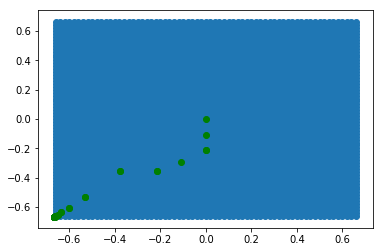

In [8]:
A = np.array([[1.5,0],
              [-1.5,0],
              [0,-1.5],
              [0,1.5]])
b = np.array([1,1,1,1]).T
c = np.array([1,1])

x, path = interior_point_method(A,b,c)
visualize(A,b[:,np.newaxis],c,path)

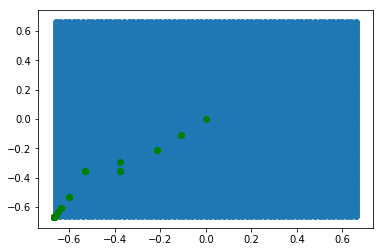

In [9]:
A = np.array([[1.5,0],
              [-1.5,0],
              [0,-1.5],
              [0,1.5]])
b = np.array([1,1,1,1]).T
c = np.array([2,1])

x, path = interior_point_method(A,b,c)
visualize(A,b[:,np.newaxis],c,path)

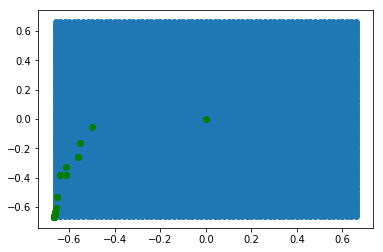

In [10]:
A = np.array([[1.5,0],
              [-1.5,0],
              [0,-1.5],
              [0,1.5]])
b = np.array([1,1,1,1]).T
c = np.array([10,1])

x, path = interior_point_method(A,b,c)
visualize(A,b[:,np.newaxis],c,path)

More clearly understand borders (=> barrier function) effect on path to the min

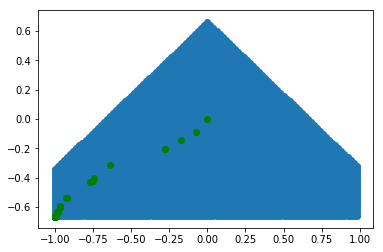

In [11]:
A0 = np.array([[1,0],
              [-1,0],
              [0,-1],
              [0,1]])
b0 = np.array([1,1,1,1]).T

A = np.array([[1.5,1.5],
              [-1.5,1.5],
              [0,-1.5],
              [0,1.5]])
b = np.array([1,1,1,1]).T
c = np.array([2,1])

A = np.concatenate((A,A0),axis=0)
b = np.concatenate((b,b0),axis=0)

x, path = interior_point_method(A,b,c)
visualize(A,b[:,np.newaxis],c,path)

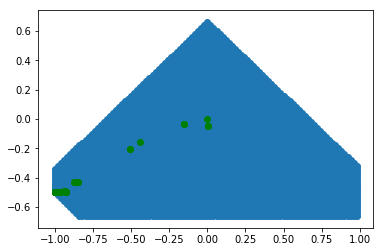

In [12]:
A0 = np.array([[1,0],
              [-1,0],
              [0,-1],
              [0,1]])
b0 = np.array([1,1,1,1]).T

A = np.array([[1.5,1.5],
              [-1.5,1.5],
              [-1,-1],
              [0,-1.5],
              [0,1.5]])
b = np.array([1,1,1.5,1,1]).T
c = np.array([2,1])

A = np.concatenate((A,A0),axis=0)
b = np.concatenate((b,b0),axis=0)

x, path = interior_point_method(A,b,c)
visualize(A,b[:,np.newaxis],c,path)

# Problem 2

{Will be tomorrow after installation of GUROBI...}

In [49]:
import numpy as np
import scipy.sparse

def Mat(road_list):
    data_list = [[city_dict[city_i], city_dict[city_j], length ] for city_i, city_j, length in road_list]
    data_array = np.asarray(data_list)
    mat = scipy.sparse.csr_matrix((data_array[:, 2], (data_array[:, 0], data_array[:, 1])), shape=(m,m), dtype=float)
    return mat

cities = ['Atlanta','Boston', 'Calgary', 'Charleston','Chicago', 'Dallas', 'Denver', 'Duluth', 'ElPaso', 
          'Helena', 'Houston', 'KansasCity', 'LasVegas', 'LittleRock', 'LosAngeles', 'Miami', 'Montreal', 
          'Nashville', 'NewOrleans', 'NewYork', 'OklahomaCity', 'Omaha', 'Phoenix', 'Pittsburgh', 
          'Portland', 'Raleigh', 'SaintLouis','SaltLakeCity', 'SanFrancisco','SantaFe', 'SaultStMarie', 
          'Seattle', 'Toronto', 'Vancouver', 'Washington', 'Winnipeg']

city_dict = {city: i for i, city in enumerate(cities)}
m = len(cities)

blue = [('Winnipeg','Helena',4), 
        ('Portland','SaltLakeCity',6), 
        ('Omaha','Chicago',4), 
        ('Montreal','NewYork',3), 
        ('KansasCity','SaintLouis',2), 
        ('SantaFe','OklahomaCity',3), 
        ('Atlanta','Miami',5)]

white = [('Calgary','Winnipeg',6), 
         ('Chicago','Toronto',4), 
         ('SaintLouis','Chicago',2), 
         ('Pittsburgh','NewYork',2),
         ('SanFrancisco','SaltLakeCity',5), 
         ('Phoenix','Denver',5), 
         ('LittleRock','Nashville',3)]

green = [('Portland','SanFrancisco',5), 
         ('Helena','Denver',4), 
         ('SaintLouis','Pittsburgh',5), 
         ('LittleRock','NewOrleans',3), 
         ('ElPaso','Houston',6)]

red = [('Helena','Omaha',5), 
       ('Denver','OklahomaCity',4), 
       ('ElPaso','Dallas',4), 
       ('NewOrleans','Miami',6),
       ('NewYork','Boston',2), 
       ('Duluth','Chicago',3)]

purple = [('Helena','SaltLakeCity',3), 
          ('Denver','Omaha',4), 
          ('Duluth','Toronto',6), 
          ('Charleston','Miami',4),
          ('SanFrancisco','LosAngeles',3)]

orange = [('LasVegas','SaltLakeCity',3), 
          ('Helena','Duluth',6), 
          ('Chicago','Pittsburgh',3), 
          ('Denver','KansasCity',4),
          ('NewYork','Washington',2), 
          ('Atlanta','NewOrleans',4)]

black = [('LosAngeles','ElPaso',6), 
         ('Winnipeg','Duluth',4), 
         ('SaultStMarie','Montreal',5), 
         ('Nashville','Raleigh',3)]

yellow = [('Seattle','Helena',6), 
          ('ElPaso','OklahomaCity',5), 
          ('Nashville','Pittsburgh',4)]

gray = [('Vancouver','Seattle',1), 
    ('Portland','Seattle',1),
    ('Vancouver','Calgary',3),
    ('Seattle','Calgary',4),
    ('Calgary','Helena',4),
    ('Winnipeg','SaultStMarie',6),
    ('Duluth','SaultStMarie',3),
    ('SaultStMarie','Toronto',2),
    ('Toronto','Montreal',3),
    ('Montreal','Boston',2),
    ('Toronto','Pittsburgh',2),
    ('LasVegas','LosAngeles',2),
    ('LosAngeles','Phoenix',3),
    ('Phoenix','ElPaso',3),
    ('ElPaso','SantaFe',2),
    ('Phoenix','SantaFe',3),
    ('SantaFe','Denver',2),
    ('Duluth','Omaha',2),
    ('Omaha','KansasCity',1),
    ('KansasCity','OklahomaCity',2),
    ('OklahomaCity','Dallas',2),
    ('Dallas','Houston',1),
    ('Houston','NewOrleans',2),
    ('Dallas','LittleRock',2),
    ('OklahomaCity','LittleRock',2),
    ('LittleRock','SaintLouis',2),
    ('SaintLouis','Nashville',2),
    ('Nashville','Atlanta',1),
    ('Atlanta','Charleston',2),
    ('Charleston','Raleigh',2),
    ('Atlanta','Raleigh',2),
    ('Raleigh','Washington',2),
    ('Raleigh','Pittsburgh',2),
    ('Washington','Pittsburgh',2)]

profit = Mat(blue)*1.+Mat(white)*1.5+Mat(green)*2.0+Mat(red)*2.0+Mat(purple)*2.5\
        +Mat(orange)*1.0+Mat(black)*1.0+Mat(yellow)*2.0+Mat(gray)*1.0
profit = profit.todense()


So, our problem is to maximize profit of the firm:
$$
\max_x \sum_{ij} p_{ij} x_{i} x_{j} - \sum_i c_i x_i 
$$
Reformulating as this:
$$
\min_x \sum_i c_i x_i + \sum_{ij} (-p_{ij} x_{i} x_{j})
$$
Let's add two vertices (source and sink), arcs between source and each city is $c_i$ and between sink and cities is $\sum_i p_{ij}$. Others are $p_{ij}$
So, we have
$$
\min_x \sum_{ij} u_{ij} (x_j - x_i), \\
\text{subj. to} ~ x_{N+2} = 1, x_{0} = 0, \\
x_{ij} \in \{0,1\}, \\
u_{0, i} = c_i, \\
u_{i, N+2} = \sum_j p_{ij}
$$

In [50]:
import gurobipy

N = len(cities)
M = N+2

u = np.zeros((M, M))

u[0,1 : M-1] = np.ones((N,))*10
u[1 : M-1, M-1] = np.sum(profit, axis=0)

u[1 : M-1, 1 : M-1] = profit

x = cvx.Variable(M)
        
constraints = [x >= 0,x <= 1,
              x[0] == 0,
              x[-1] == 1]

to_min = []
for i in range(M):
    for j in range(M):
        to_min.append(u[i,j] * cvx.pos(x[j] - x[i]))
        
obj = cvx.Minimize(np.sum(to_min))

prob = cvx.Problem(obj, constraints)
prob.solve(solver='GUROBI')

cities_opened = 0
for i in range(M-1):
    if x.value[i] == 1:
        print(cities[i-1])
        cities_opened += 1
print("Was opened %d depots"%(cities_opened))

Atlanta
Calgary
Charleston
Chicago
Dallas
Denver
Duluth
ElPaso
Helena
Houston
LittleRock
LosAngeles
Miami
Nashville
NewOrleans
OklahomaCity
Omaha
Phoenix
Pittsburgh
Portland
SaintLouis
SaltLakeCity
SanFrancisco
SaultStMarie
Seattle
Toronto
Winnipeg
Was opened 27 depots


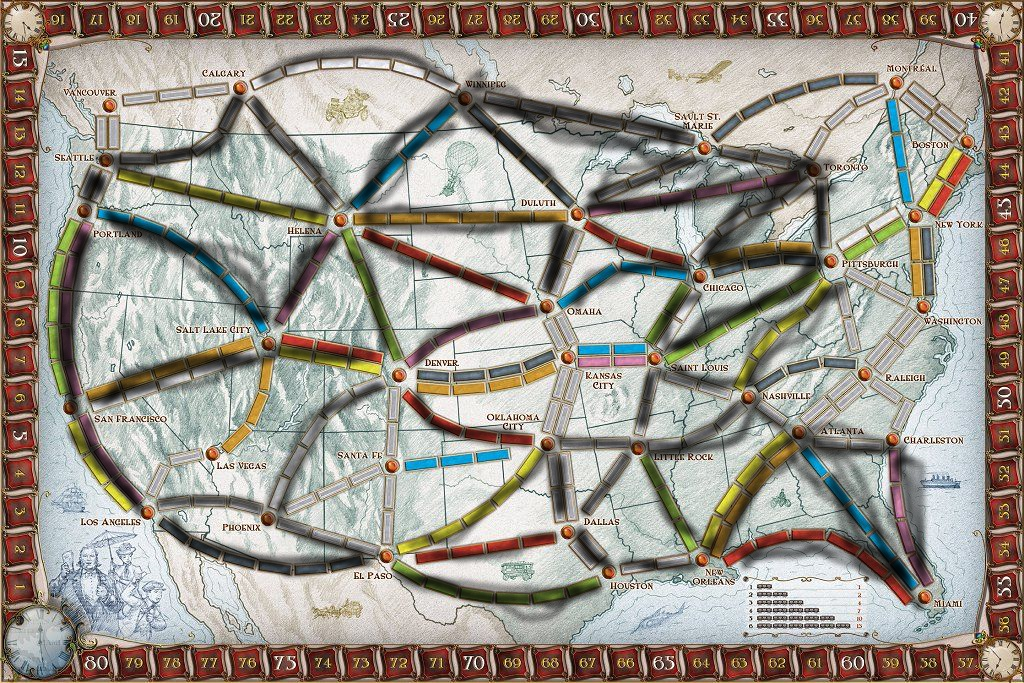

In [48]:
import IPython.display 
IPython.display.Image(filename='TicketToRide_marked.png')